sfsdfsdおれ

In [2]:
%pip install pandas
%pip install tqdm
%pip install re
%pip install sklearn
%pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
     

In [5]:
import pandas as pd

# データAとデータBのCSVファイルのパス
data_a_path = '../data/original_data/race_table/combined.csv'  # データAのCSVファイルパス
data_b_path = '../data/merged_data/merged_sorted.csv'  # データBのCSVファイルパス

# CSVファイルからデータを読み込む
data_a = pd.read_csv(data_a_path,low_memory=False)
data_b = pd.read_csv(data_b_path)
data_a=data_a.dropna()
data_b=data_b.dropna()
data_a=data_a.drop(columns=['first_horses', 'second_horses', 'third_horses', 'Time', 'Jockey', 'Trainer'])
# Code列でデータを結合 (data_bにdata_aの情報を追加)
merged_data = pd.merge(data_b, data_a, on='Code', how='left')

#結果の確認
merged_data.to_csv('../notebook/data-shin/merged_data_final.csv', index=False)
for i in merged_data.columns:
    # 各列のユニークな値とその出現回数を取得
    value_counts = df[i].value_counts()  # 各値とそのカウント
    print(f"{i}: {value_counts}")


/tmp/ipykernel_1125/1400195009.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_b = pd.read_csv(data_b_path)


特徴量の析出

In [9]:
import pandas as pd
import re
from tqdm import tqdm

file_path = '../notebook/data-shin/merged_data_final.csv'
# CSVファイルの読み込み
df = pd.read_csv(file_path)
# 12桁のコードのみを抽出
df = df[df['Code'].astype(str).str.match(r'^\d{12}$')]

# 正規表現の事前コンパイル（前後にある任意の空白を無視）
time_pattern1 = re.compile(r'\s*(\d+):(\d+\.\d+)\s*')
time_pattern2 = re.compile(r'\s*(\d+):(\d+):(\d+)\s*')
sex_age_pattern = re.compile(r'\s*([牡牝セ])(\d+)\s*')
distance_pattern = re.compile(r'\s*([ダ芝障])(\d+)\s*')
condition_pattern = re.compile(r'\s*([良重稍不])\s*')
weather_pattern = re.compile(r'\s*(晴|曇|小雨|雨|雪|小雪)\s*')
kinryou_pattern = re.compile(r'(\d+)\(([\+\-]?\d+)\)')


# 時間を秒に変換する関数 (ベクトル化)
def time_to_seconds(time_series):
    result = []
    for time_str in time_series:
        if isinstance(time_str, str):
            match1 = time_pattern1.match(time_str)
            if match1:
                minutes, seconds = int(match1.group(1)), float(match1.group(2))
                result.append(minutes * 60 + seconds)
                continue
            match2 = time_pattern2.match(time_str)
            if match2:
                minutes, seconds = int(match2.group(1)), float(match2.group(2))
                result.append(minutes * 60 + seconds)
                continue
        result.append(None)
    return result


# 性別と年齢を抽出する関数（ベクトル化）
def extract_sex_age_column(sex_age_series):
    sexes, ages = [], []
    for text in sex_age_series:
        match = sex_age_pattern.match(text) if isinstance(text, str) else None
        if match:
            sex = match.group(1)
            if sex in ['牡', '牝', 'セ']:  # 性別が牡、牝、セのみを許可
                sexes.append(sex)
                ages.append(int(match.group(2)))
            else:
                sexes.append(None)
                ages.append(None)
        else:
            sexes.append(None)
            ages.append(None)
    return pd.DataFrame({'Sex': sexes, 'Age': ages})


# 距離を抽出する関数（ベクトル化）
def extract_distance_column(distance_series):
    statuses, distances = [], []
    for text in distance_series:
        match = distance_pattern.match(text) if isinstance(text, str) else None
        if match:
            statuses.append(match.group(1))
            distances.append(int(match.group(2)))
        else:
            statuses.append(None)
            distances.append(None)
    return pd.DataFrame({'Sta': statuses, 'Dis': distances})


# 条件を抽出する関数（ベクトル化）
def extract_condition_column(condition_series):
    conditions = []
    
    for text in condition_series:
        match = condition_pattern.match(text) if isinstance(text, str) else None
        if match:
            conditions.append(match.group(1))
        else:
            conditions.append(None)
    return pd.Series(conditions)


# 天気を抽出する関数（ベクトル化）
def extract_weather_column(weather_series):
    weathers = []
    for text in weather_series:
        match = weather_pattern.match(text) if isinstance(text, str) else None
        if match:
            weathers.append(match.group(1))
        else:
            weathers.append(None)
    return pd.Series(weathers)


# 体重の変化を抽出する関数
def extract_weight_change(weight_series):
    weights, changes = [], []
    for text in weight_series:
        match = re.match(r'(\d+)\(([\+\-]?\d+)\)', text) if isinstance(text, str) else None
        if match:
            weights.append(int(match.group(1)))  # 体重
            changes.append(int(match.group(2)))  # 変化量
        else:
            weights.append(None)
            changes.append(None)
    return pd.DataFrame({'Weight': weights, 'Change': changes})



# tqdmの進捗バーを使用して変換
tqdm.pandas()
df['Time'] = time_to_seconds(df['Time'].values)

# SexとAgeの列に分割して格納
sex_age_df = extract_sex_age_column(df['Sex/Age'].values)
df[['Sex', 'Age']] = sex_age_df

# StaとDisの列に分割して格納
distance_df = extract_distance_column(df['Distance'].values)
df[['Sta', 'Dis']] = distance_df

# Conditionの列に分割して格納
df['Condition'] = extract_condition_column(df['Condition'].values)

# Weatherの列に分割して格納
df['Weather'] = extract_weather_column(df['Weather'].values)
# 新しいカラム 'Horse Weight' を追加して処理
weight_change_df = extract_weight_change(df['Horse Weight'].values)
df[['Weight', 'Change']] = weight_change_df

# NaN 値が含まれている行をフィルタリング
df = df.dropna(subset=['Sex', 'Age', 'Sta', 'Dis', 'Condition', 'Weather'])

# 不要な列を削除
df = df.drop('Sex/Age', axis=1)
df = df.drop('Distance', axis=1)
df=df.drop('Horse Weight',axis=1)
# フィルタリングしたデータをCSVに保存
df.to_csv('../notebook/data-shin/filtered_data.csv', index=False)

/tmp/ipykernel_1125/1133966646.py:7: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [1]:
import pandas as pd
import numpy as np

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv')

# 必要なカテゴリ変数の数値化
# 方法1: 文字列カテゴリを整数に変換
df['Horse Name'] = pd.factorize(df['Horse Name'])[0]
df['Jockey'] = pd.factorize(df['Jockey'])[0]
df['Trainer'] = pd.factorize(df['Trainer'])[0]
df['Banushi'] = pd.factorize(df['Banushi'])[0]
df['Track'] = pd.factorize(df['Track'])[0]
df['Weather'] = pd.factorize(df['Weather'])[0]
df['Sex'] = pd.factorize(df['Sex'])[0]

# 方法2: 日付データをカテゴリ型に変換する例
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())  # 日付を数値化（連続した数値）

#Codeカラムを消す
df=df.drop('Code',axis=1)
df=df.drop('Horse Number',axis=1)
df=df.drop('Date',axis=1)
# Weight列の処理 - '5(降)'のような文字列から数値のみを抽出
df['Weight'] = df['Weight'].apply(lambda x: float(str(x).split('(')[0]) if pd.notnull(x) else np.nan)
df['Change'] = df['Change'].apply(lambda x: float(x) if pd.notnull(x) else np.nan)

# 数値型の列のみを選択して相関係数行列を計算
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
print(corr_matrix)
# 相関係数の絶対値を取得し、上位10ペアを抽出（対角要素を除く）
corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_pairs.append({
            'pair': (numeric_cols[i], numeric_cols[j]),
            'correlation': abs(corr_matrix.iloc[i,j])
        })

# 相関係数の絶対値で降順ソート
corr_pairs = sorted(corr_pairs, key=lambda x: x['correlation'], reverse=True)

# 上位10ペアを表示
print("Top 10 correlated pairs:")
for i, pair in enumerate(corr_pairs[:10], 1):
    print(f"{i}. {pair['pair'][0]} - {pair['pair'][1]}: {pair['correlation']:.3f}")


/tmp/ipykernel_1435/883406324.py:5: DtypeWarning: Columns (1,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../notebook/data-shin/filtered_data.csv')


             Frame Rank  Horse Name   Kinryou    Jockey      Time    Nobori  \
Frame Rank     1.000000   -0.011883 -0.000154 -0.005887  0.000284  0.019357   
Horse Name    -0.011883    1.000000 -0.132046  0.619328  0.075380 -0.067430   
Kinryou       -0.000154   -0.132046  1.000000 -0.078536  0.309331 -0.310887   
Jockey        -0.005887    0.619328 -0.078536  1.000000  0.061148 -0.035005   
Time           0.000284    0.075380  0.309331  0.061148  1.000000 -0.360421   
Nobori         0.019357   -0.067430 -0.310887 -0.035005 -0.360421  1.000000   
Ninki          0.001498    0.052998 -0.061918  0.074946  0.024220 -0.045414   
Trainer       -0.003077    0.618055 -0.102605  0.525383  0.059373 -0.051512   
Banushi       -0.004301    0.593453 -0.110018  0.447008  0.022206  0.019182   
Track         -0.023983    0.305238  0.038204  0.229157  0.133146 -0.286749   
Weather       -0.002136   -0.011594 -0.009573 -0.017670 -0.018849  0.022734   
Race Number    0.009479   -0.007677  0.212467 -0.011

機械学習でタイム予測(500000行)


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils.validation import check_is_fitted

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False, nrows=500000)

# 必要なカテゴリ変数の数値化
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# 日付データを数値化
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)

# 欠損値を含む行を削除
df = df.dropna()

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code','Horse Number'])

# 确保所有的特征列都是数值型
features = features.select_dtypes(include=[np.number])

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    model.fit(X_train, y_train)
    check_is_fitted(model)
    # テストデータに対する予測
    y_pred = model.predict(X_test)
    # 予測結果と実際のタイムの差を計算
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    # 予測タイムと実際のタイムを表示
    comparison_df = pd.DataFrame({'Actual Time': y_test, 'Predicted Time': y_pred})
    
    
    print(comparison_df.head(10))
    print(comparison_df.tail(10))
except (ValueError, AttributeError) as e:
    print(f"Error during model fitting or prediction: {e}")

Mean Squared Error: 0.964774279261972
Mean Absolute Error: 0.7408475315683093
        Actual Time  Predicted Time
440484         93.2          92.290
170130         75.4          76.226
84159          75.8          75.233
272923         84.3          85.704
195556         88.7          88.479
265601         98.1          97.176
63784          99.1          99.643
485157        103.8         105.160
385200         69.0          69.347
14127          78.2          77.399
        Actual Time  Predicted Time
58116          93.8          93.299
186338         93.5          94.570
257155         91.3          91.065
336424         92.4          93.133
30412         114.3         113.148
116819        116.2         116.077
459483         93.5          92.921
432530         85.7          87.369
299024         78.5          79.309
158697         77.5          77.423


GPU加速on

In [6]:
%pip install tensorflow-gpu
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/ximihu/.local/lib/python3.10/site-packages/packaging/_parser.py", line 124, in _parse_requirement_details
          marker = _p

Mean Squared Error (MSE): 0.9647742792619719
Mean Absolute Error (MAE): 0.7408475315683093
R² Score: 0.9975617383110674
Cross-Validation MAE: 0.7508796603788739
        Actual Time  Predicted Time
440484         93.2          92.290
170130         75.4          76.226
84159          75.8          75.233
272923         84.3          85.704
195556         88.7          88.479
265601         98.1          97.176
63784          99.1          99.643
485157        103.8         105.160
385200         69.0          69.347
14127          78.2          77.399
        Actual Time  Predicted Time
58116          93.8          93.299
186338         93.5          94.570
257155         91.3          91.065
336424         92.4          93.133
30412         114.3         113.148
116819        116.2         116.077
459483         93.5          92.921
432530         85.7          87.369
299024         78.5          79.309
158697         77.5          77.423


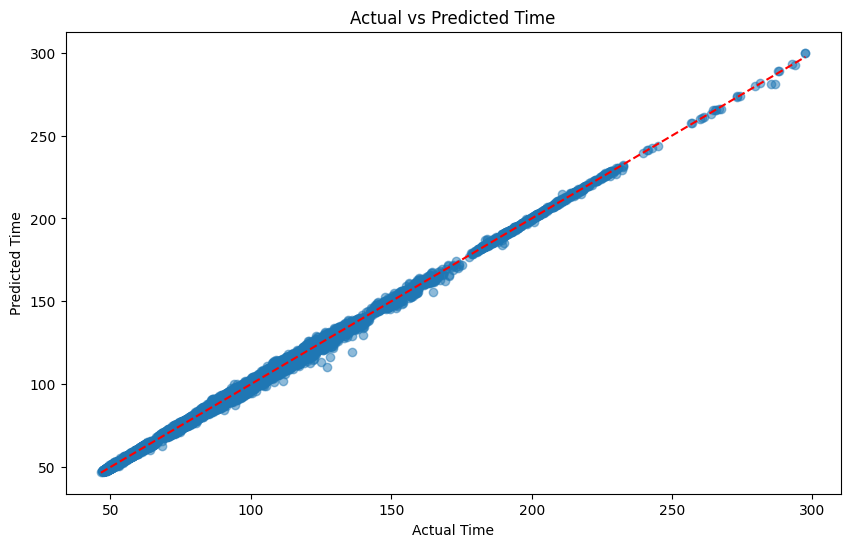

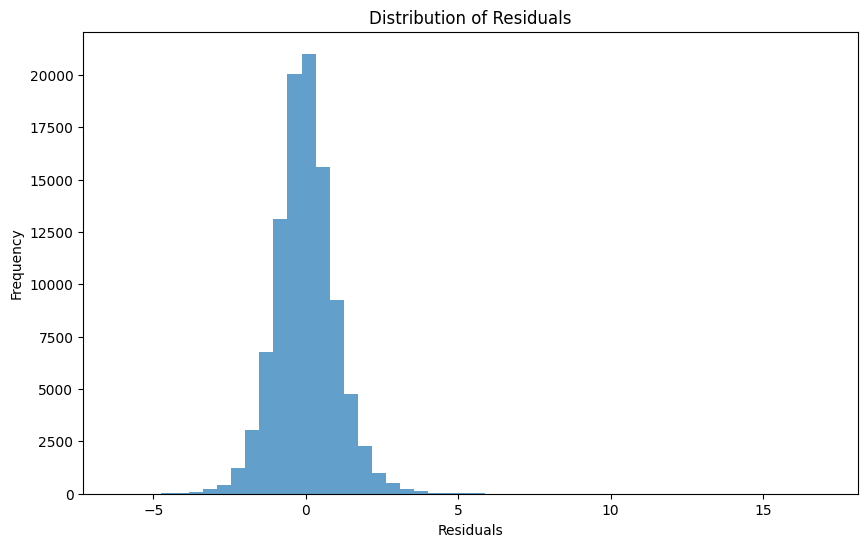

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt

# データの読み込み
df = pd.read_csv('../notebook/data-shin/filtered_data.csv', low_memory=False, nrows=500000)

# 必要なカテゴリ変数の数値化
categorical_columns = ['Horse Name', 'Jockey', 'Trainer', 'Banushi', 'Track', 'Weather', 'Sex']
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# 日付データを数値化
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(lambda date: date.toordinal())

# Weight列の処理
def extract_weight(value):
    try:
        return float(str(value).split('(')[0])
    except ValueError:
        return np.nan

df['Weight'] = df['Weight'].apply(lambda x: extract_weight(x) if pd.notnull(x) else np.nan)

# Change列の処理
def extract_change(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

df['Change'] = df['Change'].apply(lambda x: extract_change(x) if pd.notnull(x) else np.nan)

# 欠損値を含む行を削除
df = df.dropna()

# 目的変数と説明変数の設定
target = 'Time'
features = df.drop(columns=[target, 'Code','Horse Number'])
features = features.select_dtypes(include=[np.number])

# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの構築
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

try:
    # モデルの訓練
    model.fit(X_train, y_train)
    check_is_fitted(model)

    # テストデータに対する予測
    y_pred = model.predict(X_test)

    # 評価指標の計算
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R² Score: {r2}")

    # クロスバリデーションの実施（MAEを評価）
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-Validation MAE: {-np.mean(cv_scores)}")

    # 実際のタイムと予測タイムの比較
    comparison_df = pd.DataFrame({'Actual Time': y_test, 'Predicted Time': y_pred})
    print(comparison_df.head(10))
    print(comparison_df.tail(10))

    # 実際のタイムと予測タイムの散布図
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Time")
    plt.ylabel("Predicted Time")
    plt.title("Actual vs Predicted Time")
    plt.show()

    # 残差の分布をヒストグラムで可視化
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("Distribution of Residuals")
    plt.show()

except (ValueError, AttributeError) as e:
    print(f"Error during model fitting or prediction: {e}")
